In [1]:
from datasets import load_dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split

2025-12-30 23:31:48.210609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Activation de la politique mixed_float16 pour accélérer l'entraînement sur GPU
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print(f'Précision mixte: {policy.name}')

# Configuration GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f'GPU: {len(gpus)}')

Précision mixte: mixed_float16
GPU: 1


In [ ]:
# ================= 1. Chargement et nettoyage des données =================
print("\nChargement du dataset...")
ds = load_dataset("KaifengGGG/WenYanWen_English_Parallel", split="train")

# Utilisation des données = 100% pour l'instant
total_samples = len(ds)
use_samples = total_samples
print(f"Taille originale du dataset: {total_samples}")
print(f"Échantillons utilisés: {use_samples} ({use_samples/total_samples*100:.1f}%)")

np.random.seed(42)
tf.random.set_seed(42)

all_indices = np.arange(total_samples)
np.random.shuffle(all_indices)
selected_indices = all_indices[:use_samples]
ds = ds.select(selected_indices.tolist())

wenyan_texts = ds["classical"]
modern_texts = ds["modern"]
english_texts = ds["english"]

def clean_text(text):
    """Nettoie un texte: supprime les expaces en trop et caractères spéciaux."""
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = ' '.join(text.split())
    return text

wenyan_texts = [clean_text(t) for t in wenyan_texts]
modern_texts = [clean_text(t) for t in modern_texts]
english_texts = [clean_text(t) for t in english_texts]

# Filtrage des données invalides
valid_idx = [i for i in range(len(wenyan_texts)) if wenyan_texts[i] and modern_texts[i] and english_texts[i]]
print(f"Données valides : {len(valid_idx)} ({len(valid_idx)/len(wenyan_texts)*100:.1f}%)")

wenyan_texts = [wenyan_texts[i] for i in valid_idx]
modern_texts = [modern_texts[i] for i in valid_idx]
english_texts = [english_texts[i] for i in valid_idx]



Chargement du dataset...
Taille originale du dataset: 972467
Échantillons utilisés: 972467 (100.0%)
Données valides : 971853 (99.9%)


In [4]:
# ================= 2. Analyse des Dynasties =================

dynasty_rules = {
    "唐": ["TANG", "618 – 907 AD", "la dynastie TANG"],
    "宋": ["SONG", "960 – 1279 AD", "la dynastie SONG"],
    "明": ["MING", "1368 – 1644 AD", "la dynastie MING"],
    "清": ["QING", "1644 – 1912 AD", "la dynastie QING"],
    "元": ["YUAN", "1271 – 1368 AD", "la dynastie YUAN"],
    "汉": ["HAN", "202 BC – 220 AD", "la dynastie HAN"],
    "周": ["ZHOU", "1046 – 256 BC", "la dynastie ZHOU"],
    "春秋": ["ZHOU", "770 – 476 BC", "la période des Printemps et Automnes"],
    "战国": ["ZHOU", "475 – 221 BC", "la période des Royaumes Combattants"],
    "秦": ["QIN", "221 – 206 BC", "la dynastie QIN"],
    "晋": ["JIN", "266 – 420 AD", "la dynastie JIN"],
    "隋": ["SUI", "581 – 618 AD", "la dynastie SUI"],
    "三国": ["THREE_KINGDOMS", "220 – 280 AD", "la période des TROIS ROYAUMES"],
    "五代": ["FIVE_DYNASTIES", "907 – 960 AD", "la période des CINQ DYNASTIES"],
    "论语": ["ZHOU", "c. 500 BC", "l'époque de Confucius (Dynastie ZHOU)"],
    "孟子": ["ZHOU", "c. 300 BC", "la dynastie ZHOU (Royaumes Combattants)"],
    "孙子": ["ZHOU", "c. 500 BC", "la dynastie ZHOU (Stratégie militaire)"],
    "史记": ["HAN", "c. 91 BC", "la dynastie HAN (Annales historiques)"]
}

def extraire_info_livre(titre):
    # Valeur par défaut
    res = {"tag": "ANCIENT", "date": "Ancient Period", "desc": "une époque classique"}
    if not isinstance(titre, str): # Sécurité si le titre est manquant
        return res
        
    for key, val in dynasty_rules.items():
        if key in titre:
            res["tag"], res["date"], res["desc"] = val[0], val[1], val[2]
            break
    return res

print("Application des métadonnées temporelles...")

# --- CORRECTION ICI ---
# On charge explicitement en liste Python pour éviter les accès disques lents
info_titles_list = ds["info"] # Hugging Face renvoie souvent une liste, mais sécurisons
if not isinstance(info_titles_list, list):
    info_titles_list = list(ds["info"]) 

wenyan_texts_enriched = []

# Maintenant la boucle sera très rapide car tout est en RAM
for i in range(len(wenyan_texts)):
    # Utilisation de la liste chargée en mémoire
    info = extraire_info_livre(info_titles_list[i])
    
    # Format : "Time: [TAG] ([DATE]). Text: [TEXTE]"
    prompt = f"Time: {info['tag']} ({info['date']}). Text: {wenyan_texts[i]}"
    wenyan_texts_enriched.append(prompt)

wenyan_texts = wenyan_texts_enriched
print("FINI.")

Application des métadonnées temporelles...


FINI.


In [5]:
# ================= 3. Split dataset =================
print("\nSéparation dataset, train/val/test...")

# Répartition: 80/10/10 %
train_val_idx, test_idx = train_test_split(np.arange(len(wenyan_texts)), test_size=0.1, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.1111, random_state=42)  

def split_data(data_list, indices):
    """Renvoie une sous-liste basée sur les indices fournis."""
    return [data_list[i] for i in indices]

# Séparation des textes classiques, modernes et anglais
wenyan_train, wenyan_val, wenyan_test = split_data(wenyan_texts, train_idx), split_data(wenyan_texts, val_idx), split_data(wenyan_texts, test_idx)
modern_train, modern_val, modern_test = split_data(modern_texts, train_idx), split_data(modern_texts, val_idx), split_data(modern_texts, test_idx)
english_train, english_val, english_test = split_data(english_texts, train_idx), split_data(english_texts, val_idx), split_data(english_texts, test_idx)

print(f"Train: {len(train_idx)} ({len(train_idx)/len(wenyan_texts)*100:.1f}%)")
print(f"Validation: {len(val_idx)} ({len(val_idx)/len(wenyan_texts)*100:.1f}%)")
print(f"Test: {len(test_idx)} ({len(test_idx)/len(wenyan_texts)*100:.1f}%)")


Séparation dataset, train/val/test...
Train: 777491 (80.0%)
Validation: 97176 (10.0%)
Test: 97186 (10.0%)


In [6]:
# ================= 4. Tokenizer =================
class ImprovedTokenizer:
    def __init__(self, texts, max_vocab=5000):
        self.char_to_idx = {"<PAD>":0, "<START>":1, "<END>":2, "<UNK>":3}
        self.idx_to_char = {0:"<PAD>",1:"<START>",2:"<END>",3:"<UNK>"}
        char_freq = {}
        for text in texts:
            for char in text:
                char_freq[char] = char_freq.get(char,0)+1
        sorted_chars = sorted(char_freq.items(), key=lambda x:x[1], reverse=True)
        for char,_ in sorted_chars[:max_vocab-4]:
            if char_freq[char]>=2:  # au moins deux fois
                idx = len(self.char_to_idx)
                self.char_to_idx[char]=idx
                self.idx_to_char[idx]=char
        print(f"  - Taille vocabulaire: {len(self.char_to_idx)}")
    def encode(self, text, max_len):
        indices = [self.char_to_idx.get(c,3) for c in text[:max_len-2]]
        indices = [1]+indices+[2] # Start/End
        indices = indices + [0]*(max_len - len(indices))
        return indices[:max_len]
    def decode(self, indices):
        chars=[]
        for idx in indices:
            if idx in [0,2]:  # STOP si PAD ou END
                break
            if idx>3:
                chars.append(self.idx_to_char.get(idx,''))
        return ''.join(chars)

print("Chinois classique Tokenizer:")
wenyan_tok = ImprovedTokenizer(wenyan_train, max_vocab=4000)
print("Chinois moderne Tokenizer:")
modern_tok = ImprovedTokenizer(modern_train, max_vocab=5000)
print("Anglais Tokenizer:")
english_tok = ImprovedTokenizer(english_train, max_vocab=5000)


Chinois classique Tokenizer:
  - Taille vocabulaire: 4000
Chinois moderne Tokenizer:
  - Taille vocabulaire: 5000
Anglais Tokenizer:
  - Taille vocabulaire: 3138


In [7]:
# ================= 5. Prétraitement =================
print("\nPrétraitement...")

max_len_wenyan = 150
max_len_modern = 200
max_len_english = 300

# Encodage trainset
X_wenyan_train = np.array([wenyan_tok.encode(t, max_len_wenyan) for t in wenyan_train])
X_modern_train = np.array([modern_tok.encode(t, max_len_modern) for t in modern_train])
X_english_train = np.array([english_tok.encode(t, max_len_english) for t in english_train])

# Encodage valset
X_wenyan_val = np.array([wenyan_tok.encode(t, max_len_wenyan) for t in wenyan_val])
X_modern_val = np.array([modern_tok.encode(t, max_len_modern) for t in modern_val])
X_english_val = np.array([english_tok.encode(t, max_len_english) for t in english_val])

# Encodage testset
X_wenyan_test = np.array([wenyan_tok.encode(t, max_len_wenyan) for t in wenyan_test])
X_modern_test = np.array([modern_tok.encode(t, max_len_modern) for t in modern_test])
X_english_test = np.array([english_tok.encode(t, max_len_english) for t in english_test])


def prepare_decoder_data(encoder_seq, target_seq, max_len):
    """
    Prépare les entrées et cibles du décodeur
    Décalage de 1 pour les cibles (teacher forcing)
    """
    decoder_input = np.zeros((len(target_seq), max_len), dtype=np.int32)
    decoder_target = np.zeros((len(target_seq), max_len), dtype=np.int32)
    for i, seq in enumerate(target_seq):
        valid = [idx for idx in seq if idx !=0]
        if len(valid) > 0:
            decoder_input[i,:min(len(valid), max_len)] = valid[:max_len]
            decoder_target[i,:min(len(valid)-1, max_len)] = valid[1:max_len+1]
    return decoder_input, decoder_target

# Préparation des données décodeur pour W2M et M2E
Y_modern_train_input, Y_modern_train_target = prepare_decoder_data(X_wenyan_train, X_modern_train, max_len_modern)
Y_english_train_input, Y_english_train_target = prepare_decoder_data(X_modern_train, X_english_train, max_len_english)

Y_modern_val_input, Y_modern_val_target = prepare_decoder_data(X_wenyan_val, X_modern_val, max_len_modern)
Y_english_val_input, Y_english_val_target = prepare_decoder_data(X_modern_val, X_english_val, max_len_english)

Y_modern_test_input, Y_modern_test_target = prepare_decoder_data(X_wenyan_test, X_modern_test, max_len_modern)
Y_english_test_input, Y_english_test_target = prepare_decoder_data(X_modern_test, X_english_test, max_len_english)

vocab_wenyan, vocab_modern, vocab_english = len(wenyan_tok.char_to_idx), len(modern_tok.char_to_idx), len(english_tok.char_to_idx)

# Ajout prétraitement modèle Chinois classique -> Anglais
Y_w2e_train_input, Y_w2e_train_target = prepare_decoder_data(X_wenyan_train, X_english_train, max_len_english)
Y_w2e_val_input, Y_w2e_val_target = prepare_decoder_data(X_wenyan_val, X_english_val, max_len_english)
Y_w2e_test_input, Y_w2e_test_target = prepare_decoder_data(X_wenyan_test, X_english_test, max_len_english)


print(f"Vocabulaire : Classique={vocab_wenyan}, Moderne={vocab_modern}, Anglais={vocab_english}")
print(f"Shape des données : X_wenyan_train={X_wenyan_train.shape}, X_modern_train={X_modern_train.shape}, X_english_train={X_english_train.shape}")


Prétraitement...
Vocabulaire : Classique=4000, Moderne=5000, Anglais=3138
Shape des données : X_wenyan_train=(777491, 150), X_modern_train=(777491, 200), X_english_train=(777491, 300)


In [8]:
# ================= 6. Structuration Transformer =================

class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, d_model, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.d_model = d_model
        
        pos = np.arange(max_len)[:, np.newaxis]
        div = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = np.zeros((1, max_len, d_model))
        pe[0, :, 0::2] = np.sin(pos * div)
        pe[0, :, 1::2] = np.cos(pos * div)
        self.pe = tf.cast(pe, tf.float16)

    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :]

    def get_config(self):
        config = super().get_config()
        config.update({
            "max_len": self.max_len,
            "d_model": self.d_model,
        })
        return config

class TransformerEncoder(layers.Layer):
    def __init__(self, d_model, num_heads, dff, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.mha = layers.MultiHeadAttention(num_heads, d_model//num_heads)
        self.ffn = keras.Sequential([layers.Dense(dff, 'gelu'), layers.Dense(d_model)])
        self.ln1, self.ln2 = layers.LayerNormalization(), layers.LayerNormalization()

    def call(self, x, mask=None):
        x = self.ln1(x + self.mha(x, x, x, attention_mask=mask))
        return self.ln2(x + self.ffn(x))

class TransformerDecoder(layers.Layer):
    def __init__(self, d_model, num_heads, dff, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.mha1 = layers.MultiHeadAttention(num_heads, d_model//num_heads)
        self.mha2 = layers.MultiHeadAttention(num_heads, d_model//num_heads)
        self.ffn = keras.Sequential([layers.Dense(dff, 'gelu'), layers.Dense(d_model)])
        self.ln1, self.ln2, self.ln3 = [layers.LayerNormalization() for _ in range(3)]

    def call(self, x, enc_out, mask=None):
        x = self.ln1(x + self.mha1(x, x, x, use_causal_mask=True, attention_mask=mask))
        x = self.ln2(x + self.mha2(x, enc_out, enc_out))
        return self.ln3(x + self.ffn(x))


def build_transformer(v_in, v_out, len_in, len_out):
    idx_in, idx_out = layers.Input((len_in,)), layers.Input((len_out,))
    emb_in = PositionalEncoding(len_in, 256)(layers.Embedding(v_in, 256, mask_zero=True)(idx_in))
    emb_out = PositionalEncoding(len_out, 256)(layers.Embedding(v_out, 256, mask_zero=True)(idx_out))
    
    enc = emb_in
    for _ in range(4): enc = TransformerEncoder(256, 8, 1024)(enc)
    dec = emb_out
    for _ in range(4): dec = TransformerDecoder(256, 8, 1024)(dec, enc)
    
    out = layers.Dense(v_out, dtype='float32')(dec)
    return keras.Model([idx_in, idx_out], out)

In [9]:
# ================= 7. Scheduler learning rate =================

# WarmupCosineDecay : scheduler LR avec warmup puis décroissance cosinusoïdale
# Compatible avec l’optimiseur Adam
class WarmupCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, peak_lr=1e-3, min_lr=1e-5):
        super().__init__()
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.peak_lr = peak_lr
        self.min_lr = min_lr
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        total_steps = tf.cast(self.total_steps, tf.float32)
        warmup_lr = self.peak_lr * step / warmup_steps
        decay_steps = total_steps - warmup_steps
        decay_progress = (step - warmup_steps) / decay_steps
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * decay_progress))
        decay_lr = self.min_lr + (self.peak_lr - self.min_lr) * cosine_decay
        return tf.where(step < warmup_steps, warmup_lr, decay_lr)

    def get_config(self):
        return {
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps,
            "peak_lr": self.peak_lr,
            "min_lr": self.min_lr
        }


In [10]:
# ================= 8. Entraînement W2M =================

print("\nConstruction...")  
batch_size=256
epochs_w2m=15 
steps_w2m=len(X_wenyan_train)//batch_size
total_steps=steps_w2m*epochs_w2m

lr_schedule=WarmupCosineDecay(steps_w2m*2, total_steps, peak_lr=5e-4, min_lr=1e-5)

model_w2m = build_transformer(vocab_wenyan, vocab_modern, max_len_wenyan, max_len_modern)
optimizer = keras.optimizers.Adam(lr_schedule)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model_w2m.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    ),
    metrics=['accuracy']
)

print(f"Paramètres W2M: {model_w2m.count_params():,}")
print(f"Configuration de l'entraînement:")
print(f"- Batch size: {batch_size}")
print(f"- Epochs: {epochs_w2m}")
print(f"- Steps per epoch: {steps_w2m}")

callbacks_w2m = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ModelCheckpoint('best_w2m.keras', save_best_only=True, monitor='val_loss')
]

print("\nEntraînement Chinois classique -> Chinois moderne(W2M)...")
history_w2m = model_w2m.fit(
    [X_wenyan_train, Y_modern_train_input], 
    np.expand_dims(Y_modern_train_target,-1),
    batch_size=batch_size, 
    epochs=epochs_w2m,
    validation_data=([X_wenyan_val, Y_modern_val_input], np.expand_dims(Y_modern_val_target,-1)),
    callbacks=callbacks_w2m, 
    verbose=1
)

print("\nEntraînement W2M terminé.")


Construction...


I0000 00:00:1767134110.824892  636326 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22314 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0b:00.0, compute capability: 8.6
/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Paramètres W2M: 10,961,800
Configuration de l'entraînement:
- Batch size: 256
- Epochs: 15
- Steps per epoch: 3037

Entraînement Chinois classique -> Chinois moderne(W2M)...
Epoch 1/15


2025-12-30 23:35:25.450117: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f4290002010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-30 23:35:25.450132: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-12-30 23:35:25.731065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-30 23:35:25.995820: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-30 23:35:28.179971: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-30 23:35:29.519694: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are

   1/3038 ━━━━━━━━━━━━━━━━━━━━ 32:01:27 38s/step - accuracy: 3.9062e-05 - loss: 8.5102

I0000 00:00:1767134151.087192  636511 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  86/3038 ━━━━━━━━━━━━━━━━━━━━ 6:02 123ms/step - accuracy: 0.1018 - loss: 8.2038

3037/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7718 - loss: 2.7740

2025-12-30 23:42:09.648161: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-30 23:42:12.460462: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-30 23:42:12.460611: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-30 23:42:12.460827: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none

3038/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7718 - loss: 2.7735

2025-12-30 23:42:32.916372: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-30 23:42:34.787589: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_88', 1048 bytes spill stores, 804 bytes spill loads

2025-12-30 23:42:53.627254: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-30 23:42:54.765644: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_113', 12 bytes spill stores, 12 bytes spill loads

2025-12-30 23:42:55.079682: I external/local_xla/xla/stream_executor/cuda/subprocess_c

3038/3038 ━━━━━━━━━━━━━━━━━━━━ 468s 142ms/step - accuracy: 0.8409 - loss: 1.4760 - val_accuracy: 0.8838 - val_loss: 0.6959
Epoch 2/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 396s 130ms/step - accuracy: 0.9055 - loss: 0.5287 - val_accuracy: 0.9171 - val_loss: 0.4431
Epoch 3/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 395s 130ms/step - accuracy: 0.9230 - loss: 0.3977 - val_accuracy: 0.9257 - val_loss: 0.3779
Epoch 4/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 395s 130ms/step - accuracy: 0.9283 - loss: 0.3571 - val_accuracy: 0.9289 - val_loss: 0.3539
Epoch 5/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 395s 130ms/step - accuracy: 0.9314 - loss: 0.3344 - val_accuracy: 0.9309 - val_loss: 0.3397
Epoch 6/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 395s 130ms/step - accuracy: 0.9336 - loss: 0.3187 - val_accuracy: 0.9323 - val_loss: 0.3306
Epoch 7/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 394s 130ms/step - accuracy: 0.9354 - loss: 0.3065 - val_accuracy: 0.9331 - val_loss: 0.3253
Epoch 8/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 396s 130ms/step - accuracy: 0.9

In [11]:
# ================= 9. Entraînement M2E =================
epochs_m2e = 15
steps_m2e = len(X_modern_train) // batch_size
total_steps_m2e = steps_m2e * epochs_m2e

lr_schedule_m2e = WarmupCosineDecay(steps_m2e * 2, total_steps_m2e, peak_lr=5e-4, min_lr=1e-5)

model_m2e = build_transformer(vocab_modern, vocab_english, max_len_modern, max_len_english)

optimizer_m2e = keras.optimizers.Adam(lr_schedule_m2e)
optimizer_m2e = mixed_precision.LossScaleOptimizer(optimizer_m2e)

model_m2e.compile(
    optimizer=optimizer_m2e,
    loss=keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    ),
    metrics=['accuracy']
)

print(f"Paramètre M2E: {model_m2e.count_params():,}")
print(f"Configuration de l'entraînement:")
print(f"- Batch size: {batch_size}")
print(f"- Epochs: {epochs_m2e}")
print(f"- Steps per epoch: {steps_m2e}")

callbacks_m2e = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ModelCheckpoint('best_m2e.keras', save_best_only=True, monitor='val_loss'),
]

print("\nEntraînement du modèle Moderne→Anglais(M2E)...")
history_m2e = model_m2e.fit(
    [X_modern_train, Y_english_train_input], 
    np.expand_dims(Y_english_train_target, -1),
    batch_size=batch_size, 
    epochs=epochs_m2e,
    validation_data=([X_modern_val, Y_english_val_input], np.expand_dims(Y_english_val_target, -1)),
    callbacks=callbacks_m2e, 
    verbose=1
)

# Enregistrement data
test_data = {
    'wenyan': X_wenyan_test,
    'modern_input': Y_modern_test_input,
    'modern_target': Y_modern_test_target,
    'english_input': Y_english_test_input,
    'english_target': Y_english_test_target,
    'wenyan_texts': wenyan_test,
    'modern_texts': modern_test,
    'english_texts': english_test
}
np.savez('test_data.npz', **test_data)

print("\nEntraînement M2E terminé.")

/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding_2' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding_3' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Paramètre M2E: 10,262,594
Configuration de l'entraînement:
- Batch size: 256
- Epochs: 15
- Steps per epoch: 3037

Entraînement du modèle Moderne→Anglais(M2E)...
Epoch 1/15


2025-12-31 01:15:22.097445: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-31 01:15:25.687210: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2025-12-31 01:15:25.687620: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-12-31 01:15:25.882980: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 4 bytes spill stores, 4 bytes spill loads

2025-12-31 01:15:25.957656: I external/local_xla/xla/stream_executor/cuda/subpr

  94/3038 ━━━━━━━━━━━━━━━━━━━━ 8:11 167ms/step - accuracy: 0.0653 - loss: 7.9393

3037/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5595 - loss: 2.9126

2025-12-31 01:24:14.212707: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-31 01:24:17.112087: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-31 01:24:17.112260: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-31 01:24:17.112695: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none

3038/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5595 - loss: 2.9122

2025-12-31 01:24:35.673846: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_3507', 4 bytes spill stores, 4 bytes spill loads

2025-12-31 01:24:37.146362: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-31 01:24:38.053167: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_88', 4 bytes spill stores, 4 bytes spill loads

2025-12-31 01:24:38.700016: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_88', 828 bytes spill stores, 832 bytes spill loads

2025-12-31 01:25:03.091536: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:

3038/3038 ━━━━━━━━━━━━━━━━━━━━ 601s 186ms/step - accuracy: 0.6653 - loss: 1.6004 - val_accuracy: 0.7783 - val_loss: 0.7530
Epoch 2/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 532s 175ms/step - accuracy: 0.8405 - loss: 0.5401 - val_accuracy: 0.8705 - val_loss: 0.4347
Epoch 3/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 531s 175ms/step - accuracy: 0.8919 - loss: 0.3608 - val_accuracy: 0.8999 - val_loss: 0.3356
Epoch 4/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 532s 175ms/step - accuracy: 0.9109 - loss: 0.2954 - val_accuracy: 0.9147 - val_loss: 0.2832
Epoch 5/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 532s 175ms/step - accuracy: 0.9217 - loss: 0.2586 - val_accuracy: 0.9240 - val_loss: 0.2519
Epoch 6/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 532s 175ms/step - accuracy: 0.9287 - loss: 0.2344 - val_accuracy: 0.9293 - val_loss: 0.2341
Epoch 7/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 531s 175ms/step - accuracy: 0.9336 - loss: 0.2177 - val_accuracy: 0.9327 - val_loss: 0.2227
Epoch 8/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 531s 175ms/step - accuracy: 0.9

In [12]:
# ================= 10. Entraînement W2E =================
epochs_w2e = 15
steps_w2e = len(X_wenyan_train) // batch_size
total_steps_w2e = steps_w2e * epochs_w2e

lr_schedule_w2e = WarmupCosineDecay(steps_w2e * 2, total_steps_w2e, peak_lr=5e-4, min_lr=1e-5)

# Architecture : Source (Vocab Wenyan) -> Cible (Vocab English)
model_w2e = build_transformer(vocab_wenyan, vocab_english, max_len_wenyan, max_len_english)

optimizer_w2e = keras.optimizers.Adam(lr_schedule_w2e)
optimizer_w2e = mixed_precision.LossScaleOptimizer(optimizer_w2e)

model_w2e.compile(
    optimizer=optimizer_w2e,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(f"\nEntraînement du modèle Direct Classique→Anglais (W2E)...")
callbacks_w2e = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ModelCheckpoint('best_w2e.keras', save_best_only=True, monitor='val_loss'),
]

print(f"Paramètre M2E: {model_w2e.count_params():,}")
print(f"Configuration de l'entraînement:")
print(f"- Batch size: {batch_size}")
print(f"- Epochs: {epochs_w2e}")
print(f"- Steps per epoch: {steps_w2e}")

history_w2e = model_w2e.fit(
    [X_wenyan_train, Y_w2e_train_input], 
    np.expand_dims(Y_w2e_train_target, -1),
    batch_size=batch_size, 
    epochs=epochs_w2e,
    validation_data=([X_wenyan_val, Y_w2e_val_input], np.expand_dims(Y_w2e_val_target, -1)),
    callbacks=callbacks_w2e, 
    verbose=1
)

print("\nEntraînement W2E terminé.")

/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding_4' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding_5' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



Entraînement du modèle Direct Classique→Anglais (W2E)...
Paramètre M2E: 10,006,594
Configuration de l'entraînement:
- Batch size: 256
- Epochs: 15
- Steps per epoch: 3037
Epoch 1/15


2025-12-31 03:29:34.594718: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-31 03:29:38.538791: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_306', 4 bytes spill stores, 4 bytes spill loads

2025-12-31 03:29:38.755540: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_303', 40 bytes spill stores, 40 bytes spill loads

2025-12-31 03:29:38.915255: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_303', 112 bytes spill stores, 112 bytes spill loads

2025-12-31 03:29:39.001749: I external/local_xla/xla/stream_execut

3037/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5599 - loss: 2.8675

2025-12-31 03:37:58.603929: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-31 03:38:01.559293: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-31 03:38:01.559387: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-31 03:38:01.904532: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled 

3038/3038 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5599 - loss: 2.8671

2025-12-31 03:38:17.789062: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'fusion_3501', 4 bytes spill stores, 4 bytes spill loads

2025-12-31 03:38:19.269836: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-31 03:38:42.754065: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-31 03:38:43.884464: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_115', 696 bytes spill stores, 696 bytes spill loads



3038/3038 ━━━━━━━━━━━━━━━━━━━━ 568s 176ms/step - accuracy: 0.6642 - loss: 1.5885 - val_accuracy: 0.7756 - val_loss: 0.7597
Epoch 2/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 505s 166ms/step - accuracy: 0.8265 - loss: 0.5837 - val_accuracy: 0.8556 - val_loss: 0.4864
Epoch 3/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 505s 166ms/step - accuracy: 0.8744 - loss: 0.4200 - val_accuracy: 0.8827 - val_loss: 0.3910
Epoch 4/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 505s 166ms/step - accuracy: 0.8914 - loss: 0.3611 - val_accuracy: 0.8950 - val_loss: 0.3495
Epoch 5/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 504s 166ms/step - accuracy: 0.9006 - loss: 0.3293 - val_accuracy: 0.9032 - val_loss: 0.3210
Epoch 6/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 505s 166ms/step - accuracy: 0.9065 - loss: 0.3088 - val_accuracy: 0.9074 - val_loss: 0.3068
Epoch 7/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 505s 166ms/step - accuracy: 0.9108 - loss: 0.2943 - val_accuracy: 0.9103 - val_loss: 0.2972
Epoch 8/15
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 504s 166ms/step - accuracy: 0.9

--- Classique-Moderne (W2M) ---
Meilleur Epoch : 14, val_loss = 0.3107


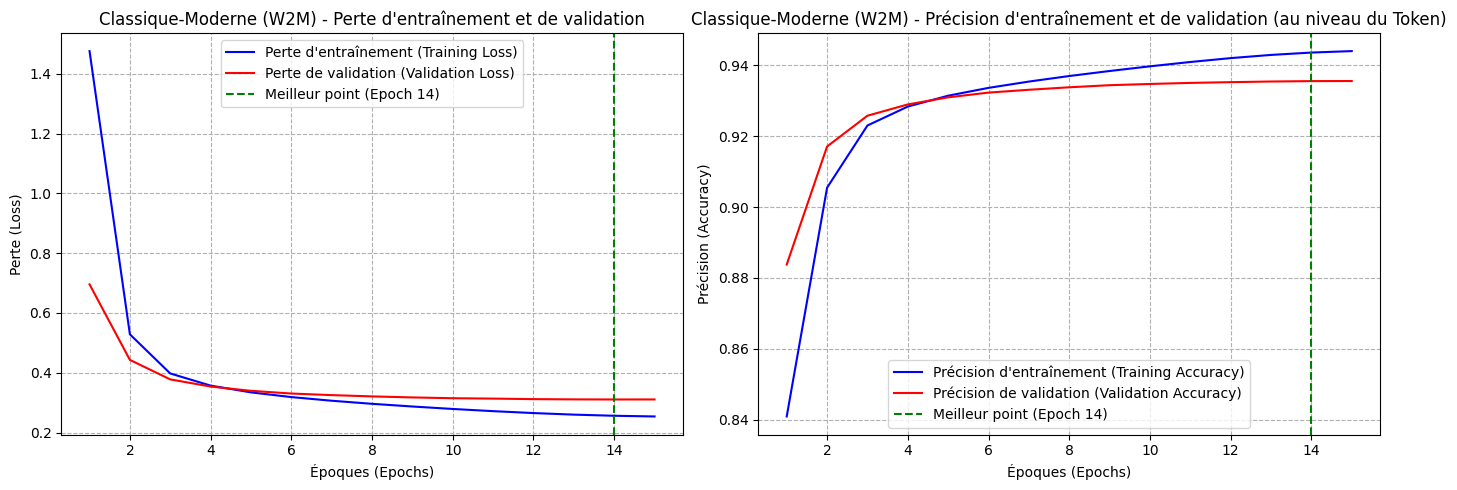

--- Moderne-Anglais (M2E) ---
Meilleur Epoch : 15, val_loss = 0.1891


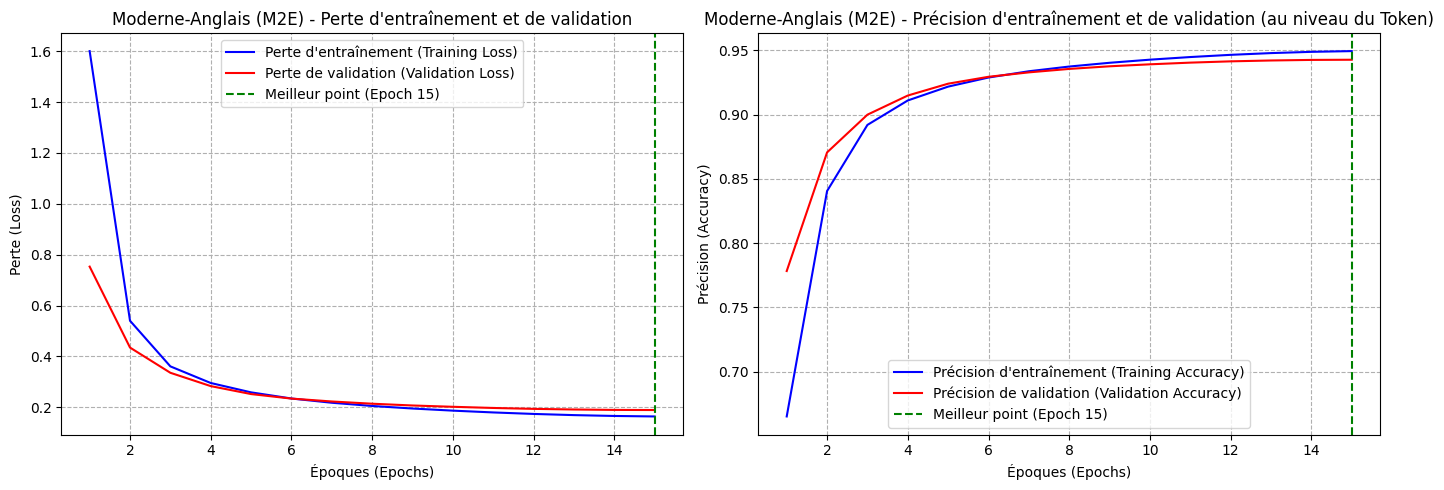

--- Classique-Anglais Direct (W2E) ---
Meilleur Epoch : 15, val_loss = 0.2681


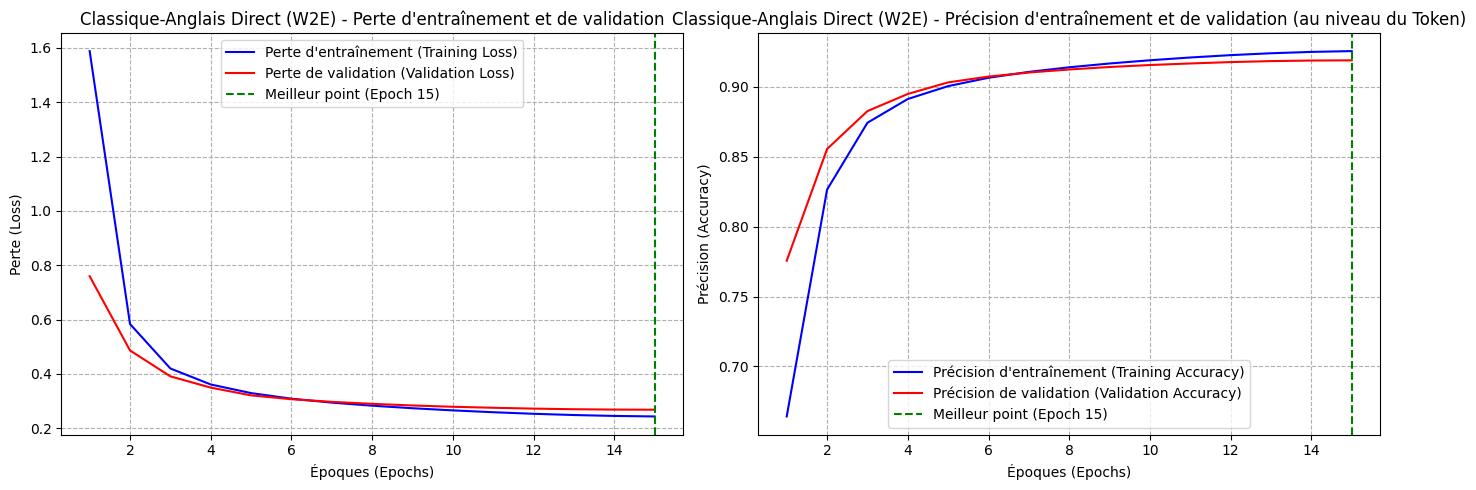

In [13]:
# ================= 11. Graphe de l'entraînement =================

import matplotlib.pyplot as plt

def plot_training_history_fr(history, model_name):
    if not history:
        print(f"Aucune donnée d'entraînement trouvée pour {model_name}.")
        return

    # Extraction des données
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    
    # Trouver le meilleur Epoch restauré par EarlyStopping
    best_val_loss = min(val_loss)
    best_epoch = val_loss.index(best_val_loss) + 1
    print(f"Meilleur Epoch : {best_epoch}, val_loss = {best_val_loss:.4f}")
    
    plt.figure(figsize=(14, 5))

    # Dessin de la courbe de perte (Loss)
    plt.subplot(1, 2, 1)
    # LÉGENDES ET TITRES
    plt.plot(epochs, loss, 'b-', label="Perte d'entraînement (Training Loss)")
    plt.plot(epochs, val_loss, 'r-', label='Perte de validation (Validation Loss)')
    plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Meilleur point (Epoch {best_epoch})')
    plt.title(f'{model_name} - Perte d\'entraînement et de validation')
    plt.xlabel('Époques (Epochs)')
    plt.ylabel('Perte (Loss)')
    plt.legend()
    plt.grid(True, linestyle='--')

    # Dessin de la courbe de précision (Accuracy)
    plt.subplot(1, 2, 2)
    # LÉGENDES ET TITRES
    plt.plot(epochs, accuracy, 'b-', label="Précision d'entraînement (Training Accuracy)")
    plt.plot(epochs, val_accuracy, 'r-', label='Précision de validation (Validation Accuracy)')
    plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Meilleur point (Epoch {best_epoch})')
    plt.title(f'{model_name} - Précision d\'entraînement et de validation (au niveau du Token)')
    plt.xlabel('Époques (Epochs)')
    plt.ylabel('Précision (Accuracy)')
    plt.legend()
    plt.grid(True, linestyle='--')

    plt.tight_layout()
    plt.show()

print("--- Classique-Moderne (W2M) ---")
plot_training_history_fr(history_w2m, "Classique-Moderne (W2M)")
print("--- Moderne-Anglais (M2E) ---")
plot_training_history_fr(history_m2e, "Moderne-Anglais (M2E)")
print("--- Classique-Anglais Direct (W2E) ---")
plot_training_history_fr(history_w2e, "Classique-Anglais Direct (W2E)")

In [14]:
"""
# APPLIQUÉ LES MODÈLES

model_w2m = keras.models.load_model(
    "best_w2m.keras",
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "TransformerEncoder": TransformerEncoder,
        "TransformerDecoder": TransformerDecoder,
        "WarmupCosineDecay": WarmupCosineDecay
    },
    compile=False
)

model_m2e = keras.models.load_model(
    "best_m2e.keras",
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "TransformerEncoder": TransformerEncoder,
        "TransformerDecoder": TransformerDecoder,
        "WarmupCosineDecay": WarmupCosineDecay
    },
    compile=False
)

model_w2e = keras.models.load_model(
    "best_w2e.keras",
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "TransformerEncoder": TransformerEncoder,
        "TransformerDecoder": TransformerDecoder,
        "WarmupCosineDecay": WarmupCosineDecay
    },
    compile=False
)
"""

'\n# APPLIQUÉ LES MODÈLES\n\nmodel_w2m = keras.models.load_model(\n    "best_w2m.keras",\n    custom_objects={\n        "PositionalEncoding": PositionalEncoding,\n        "TransformerEncoder": TransformerEncoder,\n        "TransformerDecoder": TransformerDecoder,\n        "WarmupCosineDecay": WarmupCosineDecay\n    },\n    compile=False\n)\n\nmodel_m2e = keras.models.load_model(\n    "best_m2e.keras",\n    custom_objects={\n        "PositionalEncoding": PositionalEncoding,\n        "TransformerEncoder": TransformerEncoder,\n        "TransformerDecoder": TransformerDecoder,\n        "WarmupCosineDecay": WarmupCosineDecay\n    },\n    compile=False\n)\n\nmodel_w2e = keras.models.load_model(\n    "best_w2e.keras",\n    custom_objects={\n        "PositionalEncoding": PositionalEncoding,\n        "TransformerEncoder": TransformerEncoder,\n        "TransformerDecoder": TransformerDecoder,\n        "WarmupCosineDecay": WarmupCosineDecay\n    },\n    compile=False\n)\n'

In [15]:
# ================= 13. Évaluation Qualificative =================

def evaluate_sentence_improved(sentence, model, tokenizer_in, tokenizer_out, max_len_in, max_len_out):
    input_indices = tokenizer_in.encode(sentence, max_len_in)
    encoder_input = tf.expand_dims(input_indices, 0)
    output_seq = [1] 

    for i in range(max_len_out - 1):
        decoder_input_np = np.zeros((1, max_len_out), dtype='int32')
        decoder_input_np[0, :len(output_seq)] = output_seq
        decoder_input_tensor = tf.convert_to_tensor(decoder_input_np)
        
        predictions = model([encoder_input, decoder_input_tensor], training=False)
        last_token_index = len(output_seq) - 1
        predicted_logits = predictions[0, last_token_index, :]

        for token_id in set(output_seq):
            if token_id > 3: # On ne pénalise pas PAD, START, END, UNK
                # On convertit en tenseur pour pouvoir modifier les logits
                mask = tf.one_hot(token_id, depth=predicted_logits.shape[-1])
                predicted_logits = predicted_logits - (mask * 1.0)

        predicted_id = tf.argmax(predicted_logits, axis=-1).numpy()

        if predicted_id == 2:
            break
        output_seq.append(predicted_id)

    return tokenizer_out.decode(output_seq[1:])

def translate_comparative_pipeline(text_classical):
    print("\n" + "="*50)
    print(f"SOURCE (Classique) : {text_classical}")
    print("-" * 50)
    
    # --- CHEMIN 1 : CASCADE (W2M -> M2E) ---
    # Étape 1 : Classique -> Moderne
    modern_pivot = evaluate_sentence_improved(
        text_classical, model_w2m, wenyan_tok, modern_tok, max_len_wenyan, max_len_modern
    )
    # Étape 2 : Moderne -> Anglais
    english_cascade = evaluate_sentence_improved(
        modern_pivot, model_m2e, modern_tok, english_tok, max_len_modern, max_len_english
    )
    
    # --- CHEMIN 2 : DIRECT (W2E) ---
    english_direct = evaluate_sentence_improved(
        text_classical, model_w2e, wenyan_tok, english_tok, max_len_wenyan, max_len_english
    )
    
    # Affichage des résultats
    print(f"PIVOT MODERNE     : {modern_pivot}")
    print(f"ANGLAIS (CASCADE) : {english_cascade}")
    print(f"ANGLAIS (DIRECT)  : {english_direct}")
    print("="*50)
    
    return modern_pivot, english_cascade, english_direct

print("\n--- Test Set ---")
for i in range(3):
    phrase_originale = wenyan_test[i]
    titre_brut = ds[test_idx[i]]["info"]
    
    print(f"\nTest {i+1} : {titre_brut}")
    translate_comparative_pipeline(phrase_originale)


--- Test Set ---

Test 1 : 《国语·鲁语·襄公如楚》

SOURCE (Classique) : Time: ANCIENT (Ancient Period). Text: 十六年，吴王夫差伐齐，败之艾陵，使人召陈侯。
--------------------------------------------------


/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding_2' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Down

PIVOT MODERNE     : 十六年，吴王夫差率军进攻齐国，在艾陵打败了他，派人召请陈侯。
ANGLAIS (CASCADE) : In the sixteenth year, King Fucha of Wu led his army to attack Qi. He defeated him in Ailing and sent someone to summon Chen Hou.
ANGLAIS (DIRECT)  : In the sixteenth year, King Fucha of Wu attacked Qi and defeated them in Ailing and sent someone to summon Chen Hou.

Test 2 : 《梁书·列传·卷十八》

SOURCE (Classique) : Time: ANCIENT (Ancient Period). Text: 壬午，以滑、濮节度使许叔冀为汴州刺史，充滑、汴等七州节度使；以试汝州刺史刘展为滑州刺史，充副使。
--------------------------------------------------
PIVOT MODERNE     : 壬午，德宗任命滑州、濮州节度使许叔冀为汴州刺史，充任滑州、汴州等七州节度使；任命试汝州刺史刘展为滑州刺史，充任副使。
ANGLAIS (CASCADE) : On Renwu, Emperor Dezong appointed Xu Shuji, the Jiedushi of Huazhou and Puzhou, as the governor of Bianzhou and acted as the governor of seven states of Huazhou and Bianzhou; Liu Zhan, the governor of Ruzhou, was appointed as the governor of Huazhou.
ANGLAIS (DIRECT)  : On the 27th, Xu Shuji, the Jiedushi of Huazhou and Puzhou, was appointed as the governor of Bianzhou and conc

In [18]:
import pandas as pd

def generer_donnees_eval_humaine(filename="evaluation_humaines.csv"):
    """
    Génère un fichier CSV contenant 20 phrases aléatoires pour l'évaluation humaine.
    Répartit 10 phrases pour chaque membre (donc deux personne).
    """
    
    # 20 phrases aléatoire
    total_samples = 20
    indices_aleatoires = np.random.choice(len(wenyan_test), total_samples, replace=False)
    
    # Répartition des tâches: A et B
    indices_personne_A = indices_aleatoires[:10]
    indices_personne_B = indices_aleatoires[10:]
    
    lignes_de_donnees = []
    
    print(f"Génération en cours ({total_samples} phrases)...")

    def traiter_lot(indices, nom_evaluateur):
        for idx in indices:
            src_text = wenyan_test[idx]
            ref_mod = modern_test[idx]
            ref_eng = english_test[idx]
            
            pred_mod = evaluate_sentence_improved(
                src_text, model_w2m, wenyan_tok, modern_tok, max_len_wenyan, max_len_modern
            )
            pred_eng_cascade = evaluate_sentence_improved(
                pred_mod, model_m2e, modern_tok, english_tok, max_len_modern, max_len_english
            )
            pred_eng_direct = evaluate_sentence_improved(
                src_text, model_w2e, wenyan_tok, english_tok, max_len_wenyan, max_len_english
            )
            
            # Stockage 
            lignes_de_donnees.append({
                "Evaluateur": nom_evaluateur,
                "ID_Phrase": idx,
                "Source_Classique": src_text,
                "Reference_Moderne": ref_mod,
                "Pred_W2M_Moderne": pred_mod,
                "Reference_Anglais": ref_eng,
                "Pred_Cascade_Anglais": pred_eng_cascade,
                "Pred_Direct_Anglais": pred_eng_direct
            })
            print(f"Phrase ID {idx} traitée pour {nom_evaluateur}")

    traiter_lot(indices_personne_A, "Personne A")
    traiter_lot(indices_personne_B, "Personne B")
    
    # Sauvegarder en CSV
    df = pd.DataFrame(lignes_de_donnees)
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    
    print(f"\nLe fichier '{filename}' a été créé.")
    
    return df.head()

df_apercu = generer_donnees_eval_humaine()

Génération en cours (20 phrases)...


/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/mzhuge/ertix2/lib/python3.11/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'positional_encoding_2' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Down

Phrase ID 11954 traitée pour Personne A
Phrase ID 80148 traitée pour Personne A
Phrase ID 80111 traitée pour Personne A
Phrase ID 1381 traitée pour Personne A
Phrase ID 33860 traitée pour Personne A
Phrase ID 80332 traitée pour Personne A
Phrase ID 13555 traitée pour Personne A
Phrase ID 3769 traitée pour Personne A
Phrase ID 21471 traitée pour Personne A
Phrase ID 31056 traitée pour Personne A
Phrase ID 78988 traitée pour Personne B
Phrase ID 77001 traitée pour Personne B
Phrase ID 54484 traitée pour Personne B
Phrase ID 24304 traitée pour Personne B
Phrase ID 20102 traitée pour Personne B
Phrase ID 70051 traitée pour Personne B
Phrase ID 2388 traitée pour Personne B
Phrase ID 8521 traitée pour Personne B
Phrase ID 51544 traitée pour Personne B
Phrase ID 28452 traitée pour Personne B

Le fichier 'evaluation_humaines.csv' a été créé.


In [16]:
# ================= 15. Évaluation Quantitative (Score BLEU) =================

import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def tokeniser_pour_bleu(text, langue="en"):
    """
    Tokenise le texte pour le calcul du BLEU.
    - Pour l'anglais : séparation par espaces.
    - Pour le chinois : séparation par caractères (approche standard simple).
    """
    if langue == "en":
        return text.split()
    else:
        # Pour le chinois, on sépare chaque caractère
        return list(text.replace(" ", ""))

def evaluer_modele_bleu(model, inputs, references, tok_in, tok_out, max_len_in, max_len_out, name="Modèle", sample_size=100, lang_tgt="en"):
    print(f"\nCalcul du score BLEU pour : {name} (sur {sample_size} échantillons)...")
    
    references_list = []
    hypotheses_list = []
    
    # On limite l'évaluation à sample_size pour ne pas que ce soit trop long
    limit = min(sample_size, len(inputs))
    
    for i in range(limit):
        src_text = inputs[i]
        ref_text = references[i]
        
        # Prédiction
        pred_text = evaluate_sentence_improved(src_text, model, tok_in, tok_out, max_len_in, max_len_out)
        
        # Tokenisation pour BLEU
        ref_tok = tokeniser_pour_bleu(ref_text, lang_tgt)
        pred_tok = tokeniser_pour_bleu(pred_text, lang_tgt)
        
        # NLTK attend une liste de références (il peut y en avoir plusieurs par phrase)
        references_list.append([ref_tok])
        hypotheses_list.append(pred_tok)
        
        if i % 20 == 0:
            print(f"  - Traitement {i}/{limit}...")

    # Calcul du BLEU-4 (standard)
    # SmoothingFunction est utile si les phrases sont très courtes
    chencherry = SmoothingFunction()
    score = corpus_bleu(references_list, hypotheses_list, smoothing_function=chencherry.method1)
    
    print(f"Resultat {name} -> BLEU Score: {score*100:.2f}")
    return score

# --- Lancement de l'évaluation ---
# Attention : L'inférence est lente (boucle Python). On teste sur 50 à 100 phrases pour l'exemple.
# Augmentez 'sample_size' (ex: 500 ou 1000) si vous avez du temps.

SAMPLE_SIZE = 100

print("--- Évaluation des performances ---")

# 1. Évaluation W2M (Cible = Chinois Moderne)
bleu_w2m = evaluer_modele_bleu(
    model_w2m, 
    wenyan_test, 
    modern_test, 
    wenyan_tok, 
    modern_tok, 
    max_len_wenyan, 
    max_len_modern, 
    name="Classique -> Moderne",
    sample_size=SAMPLE_SIZE,
    lang_tgt="zh"
)

# 2. Évaluation M2E (Cible = Anglais)
bleu_m2e = evaluer_modele_bleu(
    model_m2e, 
    modern_test, 
    english_test, 
    modern_tok, 
    english_tok, 
    max_len_modern, 
    max_len_english, 
    name="Moderne -> Anglais",
    sample_size=SAMPLE_SIZE,
    lang_tgt="en"
)

# 3. Évaluation W2E Direct (Cible = Anglais)
bleu_w2e = evaluer_modele_bleu(
    model_w2e, 
    wenyan_test, 
    english_test, 
    wenyan_tok, 
    english_tok, 
    max_len_wenyan, 
    max_len_english, 
    name="Classique -> Anglais (Direct)",
    sample_size=SAMPLE_SIZE,
    lang_tgt="en"
)

# Tableau récapitulatif
print("\n" + "="*30)
print("RÉCAPITULATIF DES SCORES BLEU")
print("="*30)
print(f"Classique -> Moderne : {bleu_w2m*100:.2f}")
print(f"Moderne   -> Anglais : {bleu_m2e*100:.2f}")
print(f"Classique -> Anglais : {bleu_w2e*100:.2f}")
print("="*30)

--- Évaluation des performances ---

Calcul du score BLEU pour : Classique -> Moderne (sur 100 échantillons)...
  - Traitement 0/100...
  - Traitement 20/100...
  - Traitement 40/100...
  - Traitement 60/100...
  - Traitement 80/100...
Resultat Classique -> Moderne -> BLEU Score: 30.11

Calcul du score BLEU pour : Moderne -> Anglais (sur 100 échantillons)...
  - Traitement 0/100...
  - Traitement 20/100...
  - Traitement 40/100...
  - Traitement 60/100...
  - Traitement 80/100...
Resultat Moderne -> Anglais -> BLEU Score: 19.62

Calcul du score BLEU pour : Classique -> Anglais (Direct) (sur 100 échantillons)...
  - Traitement 0/100...
  - Traitement 20/100...
  - Traitement 40/100...
  - Traitement 60/100...
  - Traitement 80/100...
Resultat Classique -> Anglais (Direct) -> BLEU Score: 10.64

RÉCAPITULATIF DES SCORES BLEU
Classique -> Moderne : 30.11
Moderne   -> Anglais : 19.62
Classique -> Anglais : 10.64


In [ ]:
# ================= EVALUATION DU SCORE BLEU PIVOT=================

def evaluer_pivot_bleu(model_step1, model_step2, inputs, references, 
                       tok_src, tok_mid, tok_tgt, 
                       max_len_src, max_len_mid, max_len_tgt, 
                       sample_size=100):
    
    print(f"\nCalcul du score BLEU pour : PIVOT (Cascade) sur {sample_size} échantillons...")
    
    references_list = []
    hypotheses_list = []
    
    limit = min(sample_size, len(inputs))
    
    for i in range(limit):
        src_text = inputs[i]
        ref_text = references[i]
        
        pred_modern = evaluate_sentence_improved(
            src_text, model_step1, tok_src, tok_mid, max_len_src, max_len_mid
        )
        pred_english = evaluate_sentence_improved(
            pred_modern, model_step2, tok_mid, tok_tgt, max_len_mid, max_len_tgt
        )

        ref_tok = tokeniser_pour_bleu(ref_text, "en")
        pred_tok = tokeniser_pour_bleu(pred_english, "en")
        references_list.append([ref_tok])
        hypotheses_list.append(pred_tok)
        
        if i % 20 == 0:
            print(f"  - Pivot Traitement {i}/{limit}...")

    # Calcul du BLEU
    chencherry = SmoothingFunction()
    score = corpus_bleu(references_list, hypotheses_list, smoothing_function=chencherry.method1)
    
    print(f"Resultat PIVOT (Cascade) -> BLEU Score: {score*100:.2f}")
    return score

bleu_pivot = evaluer_pivot_bleu(
    model_step1=model_w2m,
    model_step2=model_m2e,
    inputs=wenyan_test,
    references=english_test,
    tok_src=wenyan_tok,
    tok_mid=modern_tok,
    tok_tgt=english_tok,
    max_len_src=max_len_wenyan,
    max_len_mid=max_len_modern,
    max_len_tgt=max_len_english,
    sample_size=100
)


Calcul du score BLEU pour : PIVOT (Cascade) sur 100 échantillons...
  - Pivot Traitement 0/100...
  - Pivot Traitement 20/100...
  - Pivot Traitement 40/100...
  - Pivot Traitement 60/100...
  - Pivot Traitement 80/100...
Resultat PIVOT (Cascade) -> BLEU Score: 11.64
